In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Model

In [6]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [7]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## MLP-Mixer 

In [8]:
class MixerBlock(nn.Module):
    
    def __init__(self, patch_dim, channel_dim):
        super().__init__()
        
        self.ln0 = nn.LayerNorm(channel_dim)
        self.mlp_patch = MlpBLock(patch_dim, [2])
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mlp_channel = MlpBLock(channel_dim, [2])
    
    def forward(self, x):
        ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
        ######## !!!! Can use same mixer on shape of -> N, C, P;
        
        #### mix per patch
        y = self.ln0(x) ### per channel layer normalization ?? 
        y = torch.swapaxes(y, -1, -2)
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        x = x+y
        
        #### mix per channel 
        y = self.ln1(x)
        y = self.mlp_channel(y)
        x = x+y
        return x

In [9]:
class MlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
        final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

## Patch Mixer

In [10]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [11]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, input_scale:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        
        scaled_img_size = int(image_dim[-2]*input_scale), int(image_dim[-1]*input_scale)
        if input_scale==1:
            self.scaler = lambda x: x
        else:
            self.scaler = nn.UpsamplingBilinear2d(size=scaled_img_size)
        
        print(f"Scaled Image Size: {scaled_img_size}")
        print(f"Prime factors of image size")
        print(f"H -> {get_factors(scaled_img_size[0])}")
        print(f"W -> {get_factors(scaled_img_size[1])}")
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, num_channel))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(scaled_img_size[0]*scaled_img_size[1]*num_channel, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.scaler(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

#### Final Model

In [12]:
#### model = MlpMixer((3, 32, 32), (8, 8), hidden_expansion=2.525, num_blocks=5, num_classes=10)
# model = MlpMixer((3, 32, 32), (4, 4), hidden_expansion=9.2, num_blocks=10, num_classes=10)
# model = model.to(device)

In [13]:
# model = PatchMlpMixer((3, 32, 32), patch_sizes=[5, 7], input_scale=1.1, num_blocks=10, num_classes=10)
# model = model.to(device)

In [14]:
# print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

## Load Models

In [16]:
for SEED in [147, 258, 369]:
#     model_name = f'mlp_mixer_c10_s{SEED}'
    model_name = f'patch_mixer_c10_s{SEED}'
    
    checkpoint = torch.load(f'./models/{model_name}.pth', map_location='cpu')
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

    print(model_name, best_acc, start_epoch)
    
### MLP MIXER
# mlp_mixer_c10_s147 83.56 186
# mlp_mixer_c10_s258 83.21 174
# mlp_mixer_c10_s369 83.38 189

### Patch-Only MLP MIXER
# patch_mixer_c10_s147 85.26 190
# patch_mixer_c10_s258 84.66 188
# patch_mixer_c10_s369 85.02 187

patch_mixer_c10_s147 85.26 190
patch_mixer_c10_s258 84.66 188
patch_mixer_c10_s369 85.02 187


In [19]:
a_model_name = f'mlp_mixer_c10_s{147}'
b_model_name = f'patch_mixer_c10_s{147}'

In [20]:
with open(f"./output/{a_model_name}_data.json", 'r') as f:
    a_STAT = json.load(f)
with open(f"./output/{b_model_name}_data.json", 'r') as f:
    b_STAT = json.load(f)

In [21]:
a_STAT.keys()

dict_keys(['train_stat', 'test_stat'])

In [22]:
A_train_stat = np.array(a_STAT['train_stat'])
A_test_stat = np.array(a_STAT['test_stat'])
B_train_stat = np.array(b_STAT['train_stat'])
B_test_stat = np.array(b_STAT['test_stat'])

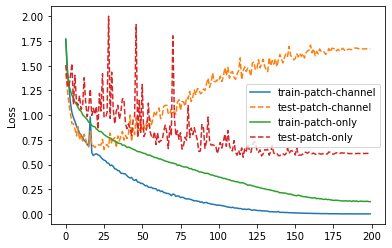

In [34]:
plt.plot(A_train_stat[:,1], label='train-patch-channel')
plt.plot(A_test_stat[:,1], label='test-patch-channel', linestyle='dashed')
plt.plot(B_train_stat[:,1], label='train-patch-only')
plt.plot(B_test_stat[:,1], label='test-patch-only', linestyle='dashed')

plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/comparision_loss.jpg")
plt.show()

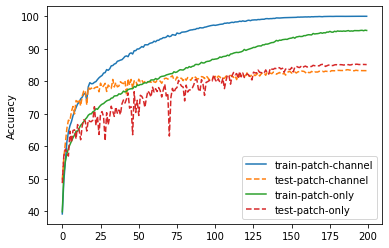

In [35]:
plt.plot(A_train_stat[:,2], label='train-patch-channel')
plt.plot(A_test_stat[:,2], label='test-patch-channel', linestyle='dashed')
plt.plot(B_train_stat[:,2], label='train-patch-only')
plt.plot(B_test_stat[:,2], label='test-patch-only', linestyle='dashed')

plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/comparision_accuracy.jpg")
plt.show()